[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Loading MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

In [11]:
# to be modified if not on colab
root_dir = '/home/andy/00_workspace/dl/data/09/content/data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [12]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        plt.title('Original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        plt.title('encode')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        plt.title('gen')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

In [ ]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        #
        # your code here
        #
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.ReLU(),
        )
    def forward(self, x):
        #
        # your code here
        #
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

In [ ]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [ ]:
sample_data = next(iter(train_loader))

In [ ]:
# torch.max(sample_data[0][0])
sample_data[0][0]

In [ ]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
# add noise to an image
def add_noise(x, noise=0.1):

    return (x + torch.rand_like(x)*noise)
# def rand_mask(x):
#     return torch.rand
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #
            # your code here to create the noisy_data
            #
            data = data.to(device).view(-1, 784)
            noisy_data = add_noise(data, noise=noise)
            optimizer.zero_grad()
            # output = model(noisy_data)
            output = model(noisy_data)
            # print(f'output.shape = {output.shape}')
            # return
            # label = (data+0.5).type(torch.LongTensor).type(torch.FloatTensor).to(device)
            # print(label.shape, label.dtype)
            # return
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
                
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)
# train_denoiser(model, nn.MSELoss(),data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

In [13]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    #
    noisy_data = add_noise(data, noise)
    decoded_imgs = model(noisy_data.view(-1, 784).to(device))
    encoded_imgs = model.encoder(noisy_data.view(-1, 784).to(device))
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

In [ ]:
plot_denoising(model, noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [ ]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2, output_padding=1)

In [ ]:
convt(y).shape

In [ ]:
convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=7)
convt3 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3,padding=1, stride=2, output_padding=1)
convt4 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1,stride=2, output_padding=1)
# convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=7)
c2 = convt2(torch.ones(2, 32, 1, 1))
c3 = convt3(c2)
c4 = convt4(c3)
print(c2.shape, c3.shape, c4.shape)

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(ConvAutoEncoder, self).__init__()
        #
        # your code here
        #
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride = 2, padding = 1), # to 14x14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride = 2, padding = 1), # to 7x7
            nn.ReLU(),
            nn.Conv2d(16, encoding_dim, kernel_size= 7, stride = 1), # to 1x1
            nn.ReLU()
        )
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(encoding_dim, 16, kernel_size = 7), # to 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # to 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), # to 28x28
            nn.ReLU()
        )
    def forward(self, x):
        #
        # your code here
        #
        return self.decoder_layers(self.encoder_layers(x.view(-1, 1, 28, 28))).view(-1, 784)
    
    def encoder(self, x):
        return self.encoder_layers(x.view(-1, 1, 28, 28)).squeeze()

In [16]:
model_conv = ConvAutoEncoder(encoding_dim=32).to(device)
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-3)


In [7]:
def add_noise(x, noise=0.1):
    return (x + torch.rand_like(x)*noise)

def train_conv_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #
            # your code here to create the noisy_data
            #
            data = data.to(device).view(-1, 784)
            noisy_data = add_noise(data, noise=noise)
            # output = model(noisy_data)
            output = model(noisy_data)
            # print(f'data.shape={data.shape}, output.shape = {output.shape}')
            # return
            # label = (data+0.5).type(torch.LongTensor).type(torch.FloatTensor).to(device)
            # print(label.shape, label.dtype)
            # return
            loss = loss_fn(output, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [18]:
# loss_fn = nn.MSELoss()
loss_fn = nn.BCEWithLogitsLoss()

In [24]:
train_conv_denoiser(model_conv, loss_fn,data_loader=train_loader,epochs=3,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.682342
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.676913
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.671832
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.671257
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.666855
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.662689
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.661628
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.659770
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.658266


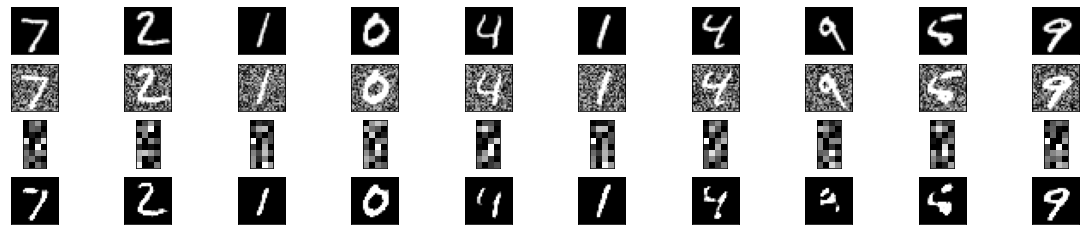

In [25]:
plot_denoising(model_conv, noise=0.8)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)